## Importing Section

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as transforms

## Importing Dataset and Transorming Data

In [2]:
num_workers = 0 
batch_size = 64

transform = transforms.ToTensor()

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers)

## Device Selection

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Discriminator and generator

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super (Discriminator, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
            
        self.linear1 = nn.Linear(self.input_size, self.hidden_size*4)
        self.linear2 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        self.linear3 = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.linear4 = nn.Linear(self.hidden_size, self.output_size)
        
        self.dropout = nn.Dropout(0.3)
    
    def forward (self, image):
        image = image.view(-1, 28*28)
        proc_img = self.linear1(image)
        proc_img = F.leaky_relu(proc_img, 0.2)
        proc_img = self.dropout(proc_img)
        proc_img = self.linear2(proc_img)
        proc_img = F.leaky_relu(proc_img, 0.2)
        proc_img = self.dropout(proc_img) 
        proc_img = self.linear3(proc_img)
        proc_img = F.leaky_relu(proc_img, 0.2)
        proc_img = self.dropout(proc_img)
        
        output = self.linear4(proc_img)

        return output
    
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super (Generator, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.linear1 = nn.Linear(input_size, self.hidden_size)
        self.linear2 = nn.Linear(self.hidden_size, self.hidden_size*2)
        self.linear3 = nn.Linear(self.hidden_size*2, self.hidden_size*4)
        self.linear4 = nn.Linear(self.hidden_size*4, self.output_size)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, latent_vector):
        l_v = self.linear1(latent_vector)
        l_v = F.leaky_relu(l_v, 0.2)
        l_v = self.dropout(l_v)
        l_v = self.linear2(l_v)
        l_v = F.leaky_relu(l_v, 0.2)
        l_v = self.dropout(l_v)
        l_v = self.linear3(l_v)
        l_v = F.leaky_relu(l_v, 0.2)
        l_v = self.dropout(l_v)
        l_v = self.linear4(l_v)
        output = F.tanh(l_v)
        
        return output 

## Instatiating and trying the Disctriminator and Generator
## Instatiating the optimizers

In [5]:
D = Discriminator(28*28, 32, 1).to(device)
G = Generator(100, 32, 28*28).to(device)

example_1 = torch.ones(1, 28, 28).to(device)
example_2 = torch.ones(1, 100).to(device)

print(D(example_1).size())
print(G(example_2).size())

optimizer_d = optim.Adam(D.parameters(), lr = 0.002)
optimizer_g = optim.Adam(G.parameters(), lr = 0.002)

torch.Size([1, 1])
torch.Size([1, 784])


/usr/lib/python3/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Custom Losses 

Due to the fact the discrimator has to learn to detect both real and fake images 
we customize two different losses.

In [18]:
def real_loss(output, smooth = False):
    
    batch_size = output.size(0)
    labels = torch.ones(batch_size).to(device)
    criterion = nn.BCEWithLogitsLoss()
    
    if smooth == True:
        loss = criterion(output.squeeze(), labels*0.9)
    else:
        loss = criterion(output.squeeze(), labels)
    
    return loss

def fake_loss(output):
    
    batch_size = output.size(0)
    labels = torch.zeros(batch_size).to(device)
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(output.squeeze(), labels)
    return loss

# Hyperparameters

In [19]:
num_epochs = 100
print_every = 400

## Training

In [20]:
losses_g = []
losses_d = []
samples = [] # This is used to save images generated

fixed_latent = np.random.uniform(-1, 1, size = (16, 100))
fixed_latent = torch.FloatTensor(fixed_latent).to(device)

D.train()

for epoch in range(num_epochs):
    G.train()
    counter = 0
    
    for real_images, _ in train_loader:
                
        real_images = real_images*2 -1 # Useful to make the images comparables to those generated by the Generator
        real_images = real_images.to(device)
        output_real = D(real_images)
        r_loss = real_loss(output_real, smooth = True)
        
        latent = np.random.uniform(-1,1, size = (batch_size, 100))
        latent = torch.FloatTensor(latent).to(device)
        fake_images = G(latent)
        output_fake = D(fake_images)
        f_loss = fake_loss(output_fake)
        
        loss_d = f_loss + r_loss
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
        
        latent = np.random.uniform(-1,1, size = (batch_size, 100))
        latent = torch.FloatTensor(latent).to(device)
        fake_images = G(latent)
        output_fake = D(fake_images)
        loss_g = real_loss(output_fake)
        
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()
        
        if counter % print_every == 0:
            print('Epoch {:5d}, Generator Loss {:6.4f}, Discriminator Loss {:6.4f}'.format(epoch, loss_g.item(), loss_d.item()))
         
        counter += 1
    # We append losses every epoch
    losses_g.append(loss_g.item())
    losses_d.append(loss_d.item())
        
    G.eval()
    samples_fake_images = G(fixed_latent)
    samples.append(samples_fake_images)

Epoch     0, Generator Loss 1.0254, Discriminator Loss 1.2997
Epoch     0, Generator Loss 0.9988, Discriminator Loss 1.3479
Epoch     0, Generator Loss 1.2595, Discriminator Loss 1.2025
Epoch     1, Generator Loss 1.0334, Discriminator Loss 1.3161
Epoch     1, Generator Loss 1.0175, Discriminator Loss 1.1743
Epoch     1, Generator Loss 1.2570, Discriminator Loss 1.5291
Epoch     2, Generator Loss 1.2896, Discriminator Loss 1.3172
Epoch     2, Generator Loss 1.1349, Discriminator Loss 1.2390
Epoch     2, Generator Loss 0.9217, Discriminator Loss 1.3516
Epoch     3, Generator Loss 0.9197, Discriminator Loss 1.2916
Epoch     3, Generator Loss 0.8254, Discriminator Loss 1.2940
Epoch     3, Generator Loss 0.9488, Discriminator Loss 1.3356
Epoch     4, Generator Loss 0.9087, Discriminator Loss 1.4621
Epoch     4, Generator Loss 0.9887, Discriminator Loss 1.2784
Epoch     4, Generator Loss 1.1563, Discriminator Loss 1.1473
Epoch     5, Generator Loss 1.1246, Discriminator Loss 1.2350
Epoch   

Epoch    44, Generator Loss 1.4851, Discriminator Loss 1.1524
Epoch    44, Generator Loss 1.3452, Discriminator Loss 1.3122
Epoch    45, Generator Loss 1.5364, Discriminator Loss 1.1381
Epoch    45, Generator Loss 0.9684, Discriminator Loss 1.2801
Epoch    45, Generator Loss 0.8678, Discriminator Loss 1.3999
Epoch    46, Generator Loss 0.9867, Discriminator Loss 1.3150
Epoch    46, Generator Loss 1.0824, Discriminator Loss 1.3211
Epoch    46, Generator Loss 1.2959, Discriminator Loss 1.2849
Epoch    47, Generator Loss 0.9998, Discriminator Loss 1.3607
Epoch    47, Generator Loss 0.8660, Discriminator Loss 1.3200
Epoch    47, Generator Loss 1.0498, Discriminator Loss 1.3337
Epoch    48, Generator Loss 0.9993, Discriminator Loss 1.2049
Epoch    48, Generator Loss 0.9840, Discriminator Loss 1.3540
Epoch    48, Generator Loss 0.9420, Discriminator Loss 1.2495
Epoch    49, Generator Loss 1.1381, Discriminator Loss 1.3801
Epoch    49, Generator Loss 0.9586, Discriminator Loss 1.2661
Epoch   

Epoch    88, Generator Loss 1.0942, Discriminator Loss 1.4185
Epoch    89, Generator Loss 1.0450, Discriminator Loss 1.3182
Epoch    89, Generator Loss 1.1820, Discriminator Loss 1.2471
Epoch    89, Generator Loss 0.9041, Discriminator Loss 1.3354
Epoch    90, Generator Loss 1.0675, Discriminator Loss 1.3255
Epoch    90, Generator Loss 1.3178, Discriminator Loss 1.2435
Epoch    90, Generator Loss 0.9133, Discriminator Loss 1.2671
Epoch    91, Generator Loss 1.2649, Discriminator Loss 1.2889
Epoch    91, Generator Loss 0.8825, Discriminator Loss 1.2575
Epoch    91, Generator Loss 0.9581, Discriminator Loss 1.3520
Epoch    92, Generator Loss 1.1197, Discriminator Loss 1.3049
Epoch    92, Generator Loss 1.0985, Discriminator Loss 1.2430
Epoch    92, Generator Loss 1.0752, Discriminator Loss 1.4130
Epoch    93, Generator Loss 0.9564, Discriminator Loss 1.2264
Epoch    93, Generator Loss 0.9663, Discriminator Loss 1.4764
Epoch    93, Generator Loss 1.1072, Discriminator Loss 1.2827
Epoch   

## Plotting Losses

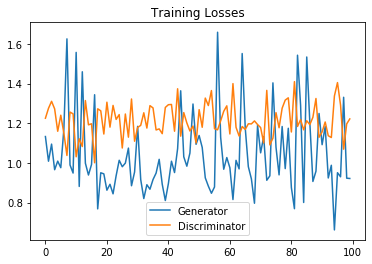

In [21]:
fig, ax = plt.subplots()
losses_g = np.asarray(losses_g)
losses_d = np.asarray(losses_d)
plt.plot(losses_g, label = 'Generator')
plt.plot(losses_d, label = 'Discriminator')

plt.title('Training Losses')
plt.legend()

## Images Generated

In [29]:
len(samples)
len(samples[0])

16

In [36]:
def view_images(epoch):
    fig, axes = plt.subplots(figsize = (7, 7), nrows = 4, ncols = 4, sharey = True, sharex = True)
    
    images = samples[epoch]
    
    for ax, img in zip(axes.flatten(), images):
        img = img.detach().cpu().numpy()
        im = ax.imshow(img.reshape((28, 28)), cmap = 'Greys_r')

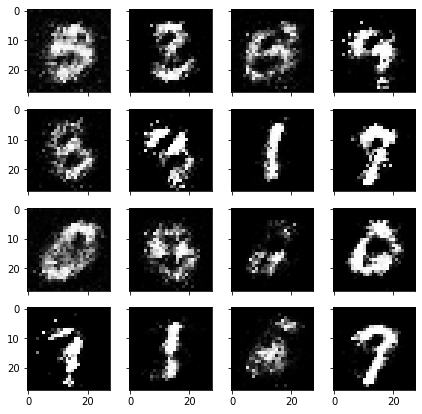

In [41]:
view_images(0)

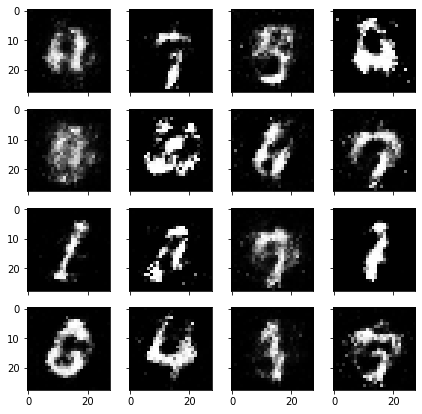

In [42]:
view_images(20)

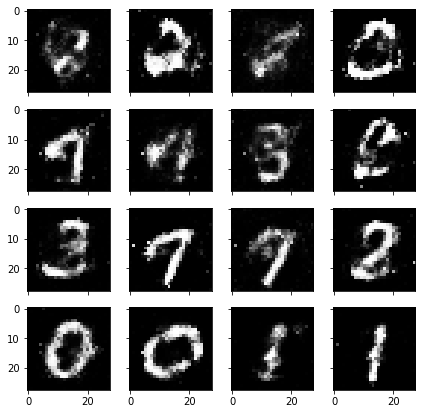

In [43]:
view_images(50)

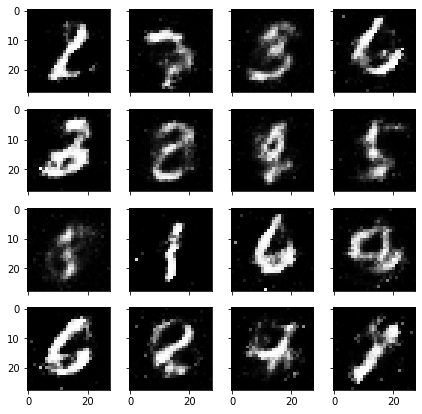

In [44]:
view_images(99)